In [1]:

# -----------------------
# Core / Numerical
# -----------------------
import warnings
import numpy as np
import pandas as pd

from itertools import combinations
from numpy import linalg
from numpy.linalg import norm

# -----------------------
# SciPy / distances
# -----------------------
from scipy.spatial.distance import pdist, squareform

# -----------------------
# Plotting
# -----------------------
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as PathEffects

# Optional: Seaborn styling with fallback palette
try:
    import seaborn as sns
except ModuleNotFoundError:
    palette = np.array(
        [
            (0.4, 0.7607843137254902, 0.6470588235294118),
            (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
            (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
            (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
            (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
            (1.0, 0.8509803921568627, 0.1843137254901961),
            (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
            (0.7019607843137254, 0.7019607843137254, 0.7019607843137254),
        ]
    )
else:
    sns.set_style("darkgrid")
    sns.set_palette("muted")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    palette = np.array(sns.color_palette("Set2"))

# -----------------------
# Scikit-learn
# -----------------------
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    pairwise_distances,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.svm import SVC, OneClassSVM
from sklearn.utils import shuffle, resample 

# -----------------------
# PennyLane (Quantum ML)
# -----------------------
import pennylane as qml
import pennylane.numpy as pnp
from pennylane.kernels import kernel_matrix, square_kernel_matrix
from pennylane.optimize import NesterovMomentumOptimizer
#import jax
#import jax.numpy as jnp


# -----------------------
# Misc
# -----------------------
warnings.filterwarnings("ignore")


c:\Users\otmas\anaconda3\Lib\site-packages\pennylane\__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(


In [2]:
RS = 42

In [3]:
# Get Data 
data = pd.read_csv("PCA_fiber.csv")
data


,Unnamed: 0,region_code_Downtown,region_code_East,region_code_Industrial,region_code_North,region_code_South,region_code_Suburban,region_code_West,link_type_Access,link_type_Aggregation,...,traffic_period_evening,traffic_period_morning,traffic_period_overnight,latency_ms,latency_jitter_ms,packet_loss_pct,error_rate,reset_count,throughput_util_pct,maintenance_flag
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,11.324225,2.106861,0.118247,0.000077,0,45.960570,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,8.632439,2.030257,0.000000,0.000000,0,37.190357,0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,14.679951,0.721178,0.077039,0.000000,0,67.903547,0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,13.848729,0.244006,0.045327,0.000228,0,58.770968,0
4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,11.249959,0.721537,0.095630,0.000000,0,58.467407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,14.786192,2.050643,0.111415,0.000319,0,65.639345,0
1996,1996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,19.480694,2.016740,0.129603,0.000110,0,73.860781,0
1997,1997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,20.355287,3.688590,0.156655,0.000042,0,74.385135,0
1998,1998,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,9.132292,0.050000,0.075876,0.000220,1,50.523288,0


## Feature Number Test

In [4]:
features = data.drop(["maintenance_flag", "Unnamed: 0"], axis=1)
label = data["maintenance_flag"]
label_array = label.to_numpy()

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


### One Column

In [6]:
# PCA
pca = PCA(n_components=1, random_state=RS)
r1 = pca.fit_transform(features)

In [13]:
# Downsample Train Test Split
x_down1, y_down1 = resample(r1, label_array, n_samples=800, replace=False, random_state=RS)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_down1, y_down1, test_size = .3, stratify=y_down1, random_state=RS)

print(x_train_1.shape)
print(x_train_1[0].shape)

(560, 1)
(1,)


In [14]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [15]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel)


In [10]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

ROC AUC: 0.4896645205015249
PR AUC: 0.05524604245153143
Precision: 0.05263157894736842
Recall: 0.46153846153846156
F1 Score: 0.09448818897637795
Accuracy: 0.5208333333333334


### Two Column

In [14]:
# PCA
pca = PCA(n_components=2, random_state=RS)
r2 = pca.fit_transform(features)

In [18]:
# Downsample Train Test Split
x_down2, y_down2 = resample(r2, label_array, n_samples=800, replace=False, random_state=RS)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_down2, y_down2, test_size = .3, stratify=y_down2, random_state=RS)

print(x_train_2.shape)
print(x_train_2[0].shape)

(560, 2)
(2,)


In [19]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_2.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [22]:
PCA_kernel_train = square_kernel_matrix(x_train_2, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_2, x_train_2, kernel=quantum_kernel)


In [24]:
# Train the SVM
clf2 = SVC(kernel='precomputed', class_weight='balanced')
clf2.fit(PCA_kernel_train, y_train_2)

y_pred2 = clf2.predict(PCA_kernel_test)

# Metrics
y_scores2 = clf2.decision_function(PCA_kernel_test)
roc_auc2 = roc_auc_score(y_test_2, y_scores2)
pr_auc2 = average_precision_score(y_test_2, y_scores2)
precision2 = precision_score(y_test_2, y_pred2, average='binary')
recall2 = recall_score(y_test_2, y_pred2, average='binary')
f12 = f1_score(y_test_2, y_pred2, average='binary')
accuracy2 = accuracy_score(y_test_2, y_pred2)

print("ROC AUC:", roc_auc2)
print("PR AUC:", pr_auc2)


print(f"Precision: {precision2}")
print(f"Recall: {recall2}")
print(f"F1 Score: {f12}")
print(f"Accuracy: {accuracy2}")

ROC AUC: 0.5255845476109794
PR AUC: 0.07100546910367217
Precision: 0.05172413793103448
Recall: 0.6923076923076923
F1 Score: 0.0962566844919786
Accuracy: 0.29583333333333334


### Three Features

In [28]:
# PCA
pca = PCA(n_components=3, random_state=RS)
r3 = pca.fit_transform(features)

In [29]:
# Downsample Train Test Split
x_down3, y_down3 = resample(r3, label_array, n_samples=800, replace=False, random_state=RS)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_down3, y_down3, test_size = .3, stratify=y_down3, random_state=RS)

print(x_train_3.shape)
print(x_train_3[0].shape)

(560, 3)
(3,)


In [30]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_3.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [31]:
PCA_kernel_train = square_kernel_matrix(x_train_3, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_3, x_train_3, kernel=quantum_kernel)


In [32]:
# Train the SVM
clf3 = SVC(kernel='precomputed', class_weight='balanced')
clf3.fit(PCA_kernel_train, y_train_3)

y_pred3 = clf3.predict(PCA_kernel_test)

# Metrics
y_scores3 = clf3.decision_function(PCA_kernel_test)
roc_auc3 = roc_auc_score(y_test_3, y_scores3)
pr_auc3 = average_precision_score(y_test_3, y_scores3)
precision3 = precision_score(y_test_3, y_pred3, average='binary')
recall3 = recall_score(y_test_3, y_pred3, average='binary')
f13 = f1_score(y_test_3, y_pred3, average='binary')
accuracy3 = accuracy_score(y_test_3, y_pred3)

print("ROC AUC:", roc_auc3)
print("PR AUC:", pr_auc3)


print(f"Precision: {precision3}")
print(f"Recall: {recall3}")
print(f"F1 Score: {f13}")
print(f"Accuracy: {accuracy3}")

ROC AUC: 0.4540833615723483
PR AUC: 0.052619382919242605
Precision: 0.047244094488188976
Recall: 0.46153846153846156
F1 Score: 0.08571428571428572
Accuracy: 0.4666666666666667


### Four Features

In [34]:
# PCA
pca = PCA(n_components=4, random_state=RS)
r4 = pca.fit_transform(features)

In [ ]:
# Downsample Train Test Split
x_down4, y_down4 = resample(r4, label_array, n_samples=800, replace=False, random_state=RS)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_down4, y_down4, test_size = .3, stratify=y_down4, random_state=RS)

print(x_train_4.shape)
print(x_train_4[0].shape)

(560, 4)
(4,)


In [36]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_4.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [37]:
PCA_kernel_train = square_kernel_matrix(x_train_4, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_4, x_train_4, kernel=quantum_kernel)


In [38]:
# Train the SVM
clf4 = SVC(kernel='precomputed', class_weight='balanced')
clf4.fit(PCA_kernel_train, y_train_4)

y_pred4 = clf4.predict(PCA_kernel_test)

# Metrics
y_scores4 = clf4.decision_function(PCA_kernel_test)
roc_auc4 = roc_auc_score(y_test_4, y_scores4)
pr_auc4 = average_precision_score(y_test_4, y_scores4)
precision4 = precision_score(y_test_4, y_pred4, average='binary')
recall4 = recall_score(y_test_4, y_pred4, average='binary')
f14 = f1_score(y_test_4, y_pred4, average='binary')
accuracy4 = accuracy_score(y_test_4, y_pred4)

print("ROC AUC:", roc_auc4)
print("PR AUC:", pr_auc4)


print(f"Precision: {precision4}")
print(f"Recall: {recall4}")
print(f"F1 Score: {f14}")
print(f"Accuracy: {accuracy4}")

ROC AUC: 0.5066079295154186
PR AUC: 0.05966530879023173
Precision: 0.05172413793103448
Recall: 0.46153846153846156
F1 Score: 0.09302325581395349
Accuracy: 0.5125


### Five Features

In [39]:
# PCA
pca = PCA(n_components=5, random_state=RS)
r5 = pca.fit_transform(features)

In [40]:
# Downsample Train Test Split
x_down5, y_down5 = resample(r5, label_array, n_samples=800, replace=False, random_state=RS)
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_down5, y_down5, test_size = .3, stratify=y_down5, random_state=RS)

print(x_train_5.shape)
print(x_train_5[0].shape)

(560, 5)
(5,)


In [41]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_5.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [42]:
PCA_kernel_train = square_kernel_matrix(x_train_5, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_5, x_train_5, kernel=quantum_kernel)


In [43]:
# Train the SVM
clf5 = SVC(kernel='precomputed', class_weight='balanced')
clf5.fit(PCA_kernel_train, y_train_5)

y_pred5 = clf5.predict(PCA_kernel_test)

# Metrics
y_scores5 = clf5.decision_function(PCA_kernel_test)
roc_auc5 = roc_auc_score(y_test_5, y_scores5)
pr_auc5 = average_precision_score(y_test_5, y_scores5)
precision5 = precision_score(y_test_5, y_pred5, average='binary')
recall5 = recall_score(y_test_5, y_pred5, average='binary')
f15 = f1_score(y_test_5, y_pred5, average='binary')
accuracy5 = accuracy_score(y_test_5, y_pred5)

print("ROC AUC:", roc_auc5)
print("PR AUC:", pr_auc5)


print(f"Precision: {precision5}")
print(f"Recall: {recall5}")
print(f"F1 Score: {f15}")
print(f"Accuracy: {accuracy5}")

ROC AUC: 0.4212131480853948
PR AUC: 0.05198761579871551
Precision: 0.027522935779816515
Recall: 0.23076923076923078
F1 Score: 0.04918032786885246
Accuracy: 0.5166666666666667


### Six Features

In [45]:
# PCA
pca = PCA(n_components=6, random_state=RS)
r6 = pca.fit_transform(features)

In [46]:
# Downsample Train Test Split
x_down6, y_down6 = resample(r6, label_array, n_samples=800, replace=False, random_state=RS)
x_train_6, x_test_6, y_train_6, y_test_6 = train_test_split(x_down6, y_down6, test_size = .3, stratify=y_down6, random_state=RS)

print(x_train_6.shape)
print(x_train_6[0].shape)

(560, 6)
(6,)


In [47]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_6.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [48]:
PCA_kernel_train = square_kernel_matrix(x_train_6, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_6, x_train_6, kernel=quantum_kernel)


In [49]:
# Train the SVM
clf6 = SVC(kernel='precomputed', class_weight='balanced')
clf6.fit(PCA_kernel_train, y_train_6)

y_pred6 = clf6.predict(PCA_kernel_test)

# Metrics
y_scores6 = clf6.decision_function(PCA_kernel_test)
roc_auc6 = roc_auc_score(y_test_6, y_scores6)
pr_auc6 = average_precision_score(y_test_6, y_scores6)
precision6 = precision_score(y_test_6, y_pred6, average='binary')
recall6 = recall_score(y_test_6, y_pred6, average='binary')
f16 = f1_score(y_test_6, y_pred6, average='binary')
accuracy6 = accuracy_score(y_test_6, y_pred6)

print("ROC AUC:", roc_auc6)
print("PR AUC:", pr_auc6)


print(f"Precision: {precision6}")
print(f"Recall: {recall6}")
print(f"F1 Score: {f16}")
print(f"Accuracy: {accuracy6}")

ROC AUC: 0.4368010843781769
PR AUC: 0.05580180775607833
Precision: 0.041666666666666664
Recall: 0.3076923076923077
F1 Score: 0.07339449541284404
Accuracy: 0.5791666666666667


### Seven Features

In [50]:
# PCA
pca = PCA(n_components=7, random_state=RS)
r7 = pca.fit_transform(features)

In [51]:
# Downsample Train Test Split
x_down7, y_down7 = resample(r7, label_array, n_samples=800, replace=False, random_state=RS)
x_train_7, x_test_7, y_train_7, y_test_7 = train_test_split(x_down7, y_down7, test_size = .3, stratify=y_down7, random_state=RS)

print(x_train_7.shape)
print(x_train_7[0].shape)

(560, 7)
(7,)


In [52]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_7.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [53]:
PCA_kernel_train = square_kernel_matrix(x_train_7, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_7, x_train_7, kernel=quantum_kernel)


In [54]:
# Train the SVM
clf7 = SVC(kernel='precomputed', class_weight='balanced')
clf7.fit(PCA_kernel_train, y_train_7)

y_pred7 = clf7.predict(PCA_kernel_test)

# Metrics
y_scores7 = clf7.decision_function(PCA_kernel_test)
roc_auc7 = roc_auc_score(y_test_7, y_scores7)
pr_auc7 = average_precision_score(y_test_7, y_scores7)
precision7 = precision_score(y_test_7, y_pred7, average='binary')
recall7 = recall_score(y_test_7, y_pred7, average='binary')
f17 = f1_score(y_test_7, y_pred7, average='binary')
accuracy7 = accuracy_score(y_test_7, y_pred7)

print("ROC AUC:", roc_auc7)
print("PR AUC:", pr_auc7)


print(f"Precision: {precision7}")
print(f"Recall: {recall7}")
print(f"F1 Score: {f17}")
print(f"Accuracy: {accuracy7}")

ROC AUC: 0.41172483903761437
PR AUC: 0.08318165829440011
Precision: 0.041666666666666664
Recall: 0.23076923076923078
F1 Score: 0.07058823529411765
Accuracy: 0.6708333333333333


### Eight Features

In [55]:
# PCA
pca = PCA(n_components=8, random_state=RS)
r8 = pca.fit_transform(features)

In [56]:
# Downsample Train Test Split
x_down8, y_down8 = resample(r8, label_array, n_samples=800, replace=False, random_state=RS)
x_train_8, x_test_8, y_train_8, y_test_8 = train_test_split(x_down8, y_down8, test_size = .3, stratify=y_down8, random_state=RS)

print(x_train_8.shape)
print(x_train_8[0].shape)

(560, 8)
(8,)


In [57]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_8.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [58]:
PCA_kernel_train = square_kernel_matrix(x_train_8, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_8, x_train_8, kernel=quantum_kernel)


In [59]:
# Train the SVM
clf8 = SVC(kernel='precomputed', class_weight='balanced')
clf8.fit(PCA_kernel_train, y_train_8)

y_pred8 = clf8.predict(PCA_kernel_test)

# Metrics
y_scores8 = clf8.decision_function(PCA_kernel_test)
roc_auc8 = roc_auc_score(y_test_8, y_scores8)
pr_auc8 = average_precision_score(y_test_8, y_scores8)
precision8 = precision_score(y_test_8, y_pred8, average='binary')
recall8 = recall_score(y_test_8, y_pred8, average='binary')
f18 = f1_score(y_test_8, y_pred8, average='binary')
accuracy8 = accuracy_score(y_test_8, y_pred8)

print("ROC AUC:", roc_auc8)
print("PR AUC:", pr_auc8)


print(f"Precision: {precision8}")
print(f"Recall: {recall8}")
print(f"F1 Score: {f18}")
print(f"Accuracy: {accuracy8}")

ROC AUC: 0.4212131480853948
PR AUC: 0.12771110077024017
Precision: 0.05660377358490566
Recall: 0.23076923076923078
F1 Score: 0.09090909090909091
Accuracy: 0.75


### Nine Features

In [60]:
# PCA
pca = PCA(n_components=9, random_state=RS)
r9 = pca.fit_transform(features)

In [61]:
# Downsample Train Test Split
x_down9, y_down9 = resample(r9, label_array, n_samples=800, replace=False, random_state=RS)
x_train_9, x_test_9, y_train_9, y_test_9 = train_test_split(x_down9, y_down9, test_size = .3, stratify=y_down9, random_state=RS)

print(x_train_9.shape)
print(x_train_9[0].shape)

(560, 9)
(9,)


In [62]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_9.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [63]:
PCA_kernel_train = square_kernel_matrix(x_train_9, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_9, x_train_9, kernel=quantum_kernel)


In [64]:
# Train the SVM
clf9 = SVC(kernel='precomputed', class_weight='balanced')
clf9.fit(PCA_kernel_train, y_train_3)

y_pred9 = clf9.predict(PCA_kernel_test)

# Metrics
y_scores9 = clf9.decision_function(PCA_kernel_test)
roc_auc9 = roc_auc_score(y_test_9, y_scores9)
pr_auc9 = average_precision_score(y_test_9, y_scores9)
precision9 = precision_score(y_test_9, y_pred9, average='binary')
recall9 = recall_score(y_test_9, y_pred9, average='binary')
f19 = f1_score(y_test_9, y_pred9, average='binary')
accuracy9 = accuracy_score(y_test_9, y_pred9)

print("ROC AUC:", roc_auc9)
print("PR AUC:", pr_auc9)


print(f"Precision: {precision9}")
print(f"Recall: {recall9}")
print(f"F1 Score: {f19}")
print(f"Accuracy: {accuracy9}")

ROC AUC: 0.4378176889190105
PR AUC: 0.14227768981767014
Precision: 0.07692307692307693
Recall: 0.23076923076923078
F1 Score: 0.11538461538461539
Accuracy: 0.8083333333333333


### Ten Features

In [65]:
# PCA
pca = PCA(n_components=3, random_state=RS)
r10 = pca.fit_transform(features)

In [66]:
# Downsample Train Test Split
x_down10, y_down10 = resample(r10, label_array, n_samples=800, replace=False, random_state=RS)
x_train_10, x_test_10, y_train_10, y_test_10 = train_test_split(x_down10, y_down10, test_size = .3, stratify=y_down10, random_state=RS)

print(x_train_10.shape)
print(x_train_10[0].shape)

(560, 3)
(3,)


In [67]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_10.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [68]:
PCA_kernel_train = square_kernel_matrix(x_train_10, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_10, x_train_10, kernel=quantum_kernel)


In [69]:
# Train the SVM
clf10 = SVC(kernel='precomputed', class_weight='balanced')
clf10.fit(PCA_kernel_train, y_train_10)

y_pred10 = clf10.predict(PCA_kernel_test)

# Metrics
y_scores10 = clf10.decision_function(PCA_kernel_test)
roc_auc10 = roc_auc_score(y_test_10, y_scores10)
pr_auc10 = average_precision_score(y_test_10, y_scores10)
precision10 = precision_score(y_test_10, y_pred10, average='binary')
recall10 = recall_score(y_test_10, y_pred10, average='binary')
f110 = f1_score(y_test_10, y_pred10, average='binary')
accuracy10 = accuracy_score(y_test_10, y_pred10)

print("ROC AUC:", roc_auc10)
print("PR AUC:", pr_auc10)


print(f"Precision: {precision10}")
print(f"Recall: {recall10}")
print(f"F1 Score: {f110}")
print(f"Accuracy: {accuracy10}")

ROC AUC: 0.4540833615723483
PR AUC: 0.052619382919242605
Precision: 0.047244094488188976
Recall: 0.46153846153846156
F1 Score: 0.08571428571428572
Accuracy: 0.4666666666666667


### Eleven Features

In [70]:
# PCA
pca = PCA(n_components=11, random_state=RS)
r11 = pca.fit_transform(features)

In [71]:
# Downsample Train Test Split
x_down11, y_down11 = resample(r11, label_array, n_samples=800, replace=False, random_state=RS)
x_train_11, x_test_11, y_train_11, y_test_11 = train_test_split(x_down11, y_down11, test_size = .3, stratify=y_down11, random_state=RS)

print(x_train_11.shape)
print(x_train_11[0].shape)

(560, 11)
(11,)


In [72]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_11.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [73]:
PCA_kernel_train = square_kernel_matrix(x_train_11, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_11, x_train_11, kernel=quantum_kernel)


In [74]:
# Train the SVM
clf11 = SVC(kernel='precomputed', class_weight='balanced')
clf11.fit(PCA_kernel_train, y_train_11)

y_pred11 = clf11.predict(PCA_kernel_test)

# Metrics
y_scores11 = clf11.decision_function(PCA_kernel_test)
roc_auc11 = roc_auc_score(y_test_11, y_scores11)
pr_auc11 = average_precision_score(y_test_11, y_scores11)
precision11 = precision_score(y_test_11, y_pred11, average='binary')
recall11 = recall_score(y_test_11, y_pred11, average='binary')
f111 = f1_score(y_test_11, y_pred11, average='binary')
accuracy11 = accuracy_score(y_test_11, y_pred11)

print("ROC AUC:", roc_auc11)
print("PR AUC:", pr_auc11)


print(f"Precision: {precision11}")
print(f"Recall: {recall11}")
print(f"F1 Score: {f111}")
print(f"Accuracy: {accuracy11}")

ROC AUC: 0.40393087089122337
PR AUC: 0.14359287359248618
Precision: 0.1111111111111111
Recall: 0.23076923076923078
F1 Score: 0.15
Accuracy: 0.8583333333333333


### 12 Features

In [75]:
# PCA
pca = PCA(n_components=12, random_state=RS)
r12 = pca.fit_transform(features)

In [76]:
# Downsample Train Test Split
x_down12, y_down12 = resample(r12, label_array, n_samples=800, replace=False, random_state=RS)
x_train_12, x_test_12, y_train_12, y_test_12 = train_test_split(x_down12, y_down12, test_size = .3, stratify=y_down12, random_state=RS)

print(x_train_12.shape)
print(x_train_12[0].shape)

(560, 12)
(12,)


In [77]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_12.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [78]:
PCA_kernel_train = square_kernel_matrix(x_train_12, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_12, x_train_12, kernel=quantum_kernel)


In [80]:
# Train the SVM
clf12 = SVC(kernel='precomputed', class_weight='balanced')
clf12.fit(PCA_kernel_train, y_train_12)

y_pred12 = clf12.predict(PCA_kernel_test)

# Metrics
y_scores12 = clf12.decision_function(PCA_kernel_test)
roc_auc12 = roc_auc_score(y_test_12, y_scores12)
pr_auc12 = average_precision_score(y_test_12, y_scores12)
precision12 = precision_score(y_test_12, y_pred12, average='binary')
recall12 = recall_score(y_test_12, y_pred12, average='binary')
f112 = f1_score(y_test_12, y_pred12, average='binary')
accuracy12 = accuracy_score(y_test_12, y_pred12)

print("ROC AUC:", roc_auc12)
print("PR AUC:", pr_auc12)


print(f"Precision: {precision12}")
print(f"Recall: {recall12}")
print(f"F1 Score: {f112}")
print(f"Accuracy: {accuracy12}")

ROC AUC: 0.4049474754320569
PR AUC: 0.14533844940031188
Precision: 0.1111111111111111
Recall: 0.23076923076923078
F1 Score: 0.15
Accuracy: 0.8583333333333333


### 13 Features

In [11]:
# PCA
pca = PCA(n_components=13, random_state=RS)
r13 = pca.fit_transform(features)

In [12]:
# Downsample Train Test Split
x_down13, y_down13 = resample(r13, label_array, n_samples=800, replace=False, random_state=RS)
x_train_13, x_test_13, y_train_13, y_test_13 = train_test_split(x_down13, y_down13, test_size = .3, stratify=y_down13, random_state=RS)

print(x_train_13.shape)
print(x_train_13[0].shape)

(560, 13)
(13,)


In [13]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_13.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [14]:
PCA_kernel_train = square_kernel_matrix(x_train_13, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_13, x_train_13, kernel=quantum_kernel)


In [17]:
# Train the SVM
clf13 = SVC(kernel='precomputed', class_weight='balanced')
clf13.fit(PCA_kernel_train, y_train_13)

y_pred13 = clf13.predict(PCA_kernel_test)

# Metrics
y_scores13 = clf13.decision_function(PCA_kernel_test)
roc_auc13 = roc_auc_score(y_test_13, y_scores13)
pr_auc13 = average_precision_score(y_test_13, y_scores13)
precision13 = precision_score(y_test_13, y_pred13, average='binary')
recall13 = recall_score(y_test_13, y_pred13, average='binary')
f113 = f1_score(y_test_13, y_pred13, average='binary')
accuracy13 = accuracy_score(y_test_13, y_pred13)

print("ROC AUC:", roc_auc13)
print("PR AUC:", pr_auc13)


print(f"Precision: {precision13}")
print(f"Recall: {recall13}")
print(f"F1 Score: {f113}")
print(f"Accuracy: {accuracy13}")

ROC AUC: 0.3947814300237208
PR AUC: 0.14961111776559846
Precision: 0.14285714285714285
Recall: 0.23076923076923078
F1 Score: 0.17647058823529413
Accuracy: 0.8833333333333333


### 14 Features

In [18]:
# PCA
pca = PCA(n_components=14, random_state=RS)
r14 = pca.fit_transform(features)

In [19]:
# Downsample Train Test Split
x_down14, y_down14 = resample(r14, label_array, n_samples=800, replace=False, random_state=RS)
x_train_14, x_test_14, y_train_14, y_test_14 = train_test_split(x_down14, y_down14, test_size = .3, stratify=y_down14, random_state=RS)

print(x_train_14.shape)
print(x_train_14[0].shape)

(560, 14)
(14,)


In [20]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_14.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [21]:
PCA_kernel_train = square_kernel_matrix(x_train_14, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_14, x_train_14, kernel=quantum_kernel)


In [22]:
# Train the SVM
clf14 = SVC(kernel='precomputed', class_weight='balanced')
clf14.fit(PCA_kernel_train, y_train_14)

y_pred14 = clf14.predict(PCA_kernel_test)

# Metrics
y_scores14 = clf14.decision_function(PCA_kernel_test)
roc_auc14 = roc_auc_score(y_test_14, y_scores14)
pr_auc14 = average_precision_score(y_test_14, y_scores14)
precision14 = precision_score(y_test_14, y_pred14, average='binary')
recall14 = recall_score(y_test_14, y_pred14, average='binary')
f114 = f1_score(y_test_14, y_pred14, average='binary')
accuracy14 = accuracy_score(y_test_14, y_pred14)

print("ROC AUC:", roc_auc14)
print("PR AUC:", pr_auc14)


print(f"Precision: {precision14}")
print(f"Recall: {recall14}")
print(f"F1 Score: {f114}")
print(f"Accuracy: {accuracy14}")

ROC AUC: 0.3575059301931549
PR AUC: 0.14555274110027785
Precision: 0.1875
Recall: 0.23076923076923078
F1 Score: 0.20689655172413793
Accuracy: 0.9041666666666667


### 15 Features

In [23]:
# PCA
pca = PCA(n_components=15, random_state=RS)
r15 = pca.fit_transform(features)

In [24]:
# Downsample Train Test Split
x_down15, y_down15 = resample(r15, label_array, n_samples=800, replace=False, random_state=RS)
x_train_15, x_test_15, y_train_15, y_test_15 = train_test_split(x_down15, y_down15, test_size = .3, stratify=y_down15, random_state=RS)

print(x_train_15.shape)
print(x_train_15[0].shape)

(560, 15)
(15,)


In [25]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_15.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [26]:
PCA_kernel_train = square_kernel_matrix(x_train_15, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_15, x_train_15, kernel=quantum_kernel)


In [27]:
# Train the SVM
clf15 = SVC(kernel='precomputed', class_weight='balanced')
clf15.fit(PCA_kernel_train, y_train_15)

y_pred15 = clf15.predict(PCA_kernel_test)

# Metrics
y_scores15 = clf15.decision_function(PCA_kernel_test)
roc_auc15 = roc_auc_score(y_test_15, y_scores15)
pr_auc15 = average_precision_score(y_test_15, y_scores15)
precision15 = precision_score(y_test_15, y_pred15, average='binary')
recall15 = recall_score(y_test_15, y_pred15, average='binary')
f115 = f1_score(y_test_15, y_pred15, average='binary')
accuracy15 = accuracy_score(y_test_15, y_pred15)

print("ROC AUC:", roc_auc15)
print("PR AUC:", pr_auc15)


print(f"Precision: {precision15}")
print(f"Recall: {recall15}")
print(f"F1 Score: {f115}")
print(f"Accuracy: {accuracy15}")

ROC AUC: 0.37885462555066074
PR AUC: 0.12620569300653506
Precision: 0.07692307692307693
Recall: 0.07692307692307693
F1 Score: 0.07692307692307693
Accuracy: 0.9


### 16 Features

In [28]:
# PCA
pca = PCA(n_components=16, random_state=RS)
r16 = pca.fit_transform(features)

In [29]:
# Downsample Train Test Split
x_down16, y_down16 = resample(r16, label_array, n_samples=800, replace=False, random_state=RS)
x_train_16, x_test_16, y_train_16, y_test_16 = train_test_split(x_down16, y_down16, test_size = .3, stratify=y_down16, random_state=RS)

print(x_train_16.shape)
print(x_train_16[0].shape)

(560, 16)
(16,)


In [30]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_16.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [31]:
PCA_kernel_train = square_kernel_matrix(x_train_16, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_16, x_train_16, kernel=quantum_kernel)


In [32]:
# Train the SVM
clf16 = SVC(kernel='precomputed', class_weight='balanced')
clf16.fit(PCA_kernel_train, y_train_16)

y_pred16 = clf16.predict(PCA_kernel_test)

# Metrics
y_scores16 = clf16.decision_function(PCA_kernel_test)
roc_auc16 = roc_auc_score(y_test_16, y_scores16)
pr_auc16 = average_precision_score(y_test_16, y_scores16)
precision16 = precision_score(y_test_16, y_pred16, average='binary')
recall16 = recall_score(y_test_16, y_pred16, average='binary')
f116 = f1_score(y_test_16, y_pred16, average='binary')
accuracy16 = accuracy_score(y_test_16, y_pred16)

print("ROC AUC:", roc_auc16)
print("PR AUC:", pr_auc16)


print(f"Precision: {precision16}")
print(f"Recall: {recall16}")
print(f"F1 Score: {f116}")
print(f"Accuracy: {accuracy16}")

ROC AUC: 0.35716706201287696
PR AUC: 0.1232865431063954
Precision: 0.1111111111111111
Recall: 0.07692307692307693
F1 Score: 0.09090909090909091
Accuracy: 0.9166666666666666


### 17 Features

In [34]:
# PCA
pca = PCA(n_components=17, random_state=RS)
r17 = pca.fit_transform(features)

In [35]:
# Downsample Train Test Split
x_down17, y_down17 = resample(r17, label_array, n_samples=800, replace=False, random_state=RS)
x_train_17, x_test_17, y_train_17, y_test_17 = train_test_split(x_down17, y_down17, test_size = .3, stratify=y_down17, random_state=RS)

print(x_train_17.shape)
print(x_train_17[0].shape)

(560, 17)
(17,)


In [36]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_17.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [37]:
PCA_kernel_train = square_kernel_matrix(x_train_17, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_17, x_train_17, kernel=quantum_kernel)


In [38]:
# Train the SVM
clf17 = SVC(kernel='precomputed', class_weight='balanced')
clf17.fit(PCA_kernel_train, y_train_17)

y_pred17 = clf17.predict(PCA_kernel_test)

# Metrics
y_scores17 = clf17.decision_function(PCA_kernel_test)
roc_auc17 = roc_auc_score(y_test_17, y_scores17)
pr_auc17 = average_precision_score(y_test_17, y_scores17)
precision17 = precision_score(y_test_17, y_pred17, average='binary')
recall17 = recall_score(y_test_17, y_pred17, average='binary')
f117 = f1_score(y_test_17, y_pred17, average='binary')
accuracy17 = accuracy_score(y_test_17, y_pred17)

print("ROC AUC:", roc_auc17)
print("PR AUC:", pr_auc17)


print(f"Precision: {precision17}")
print(f"Recall: {recall17}")
print(f"F1 Score: {f117}")
print(f"Accuracy: {accuracy17}")

ROC AUC: 0.3707217892239919
PR AUC: 0.12918349930351822
Precision: 0.14285714285714285
Recall: 0.07692307692307693
F1 Score: 0.1
Accuracy: 0.925


## 18

In [39]:
# PCA
pca = PCA(n_components=18, random_state=RS)
r18 = pca.fit_transform(features)

In [40]:
# Downsample Train Test Split
x_down18, y_down18 = resample(r18, label_array, n_samples=800, replace=False, random_state=RS)
x_train_18, x_test_18, y_train_18, y_test_18 = train_test_split(x_down18, y_down18, test_size = .3, stratify=y_down18, random_state=RS)

print(x_train_18.shape)
print(x_train_18[0].shape)

(560, 18)
(18,)


In [41]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_18.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [42]:
PCA_kernel_train = square_kernel_matrix(x_train_18, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_18, x_train_18, kernel=quantum_kernel)


In [43]:
# Train the SVM
clf18 = SVC(kernel='precomputed', class_weight='balanced')
clf18.fit(PCA_kernel_train, y_train_18)

y_pred18 = clf18.predict(PCA_kernel_test)

# Metrics
y_scores18 = clf18.decision_function(PCA_kernel_test)
roc_auc18 = roc_auc_score(y_test_18, y_scores18)
pr_auc18 = average_precision_score(y_test_18, y_scores18)
precision18 = precision_score(y_test_18, y_pred18, average='binary')
recall18 = recall_score(y_test_18, y_pred18, average='binary')
f118 = f1_score(y_test_18, y_pred18, average='binary')
accuracy18 = accuracy_score(y_test_18, y_pred18)

print("ROC AUC:", roc_auc18)
print("PR AUC:", pr_auc18)


print(f"Precision: {precision18}")
print(f"Recall: {recall18}")
print(f"F1 Score: {f118}")
print(f"Accuracy: {accuracy18}")

ROC AUC: 0.3944425618434429
PR AUC: 0.1257415654160444
Precision: 0.16666666666666666
Recall: 0.07692307692307693
F1 Score: 0.10526315789473684
Accuracy: 0.9291666666666667


## 19

In [44]:
# PCA
pca = PCA(n_components=19, random_state=RS)
r19 = pca.fit_transform(features)

In [45]:
# Downsample Train Test Split
x_down19, y_down19 = resample(r19, label_array, n_samples=800, replace=False, random_state=RS)
x_train_19, x_test_19, y_train_19, y_test_19 = train_test_split(x_down19, y_down19, test_size = .3, stratify=y_down19, random_state=RS)

print(x_train_19.shape)
print(x_train_19[0].shape)

(560, 19)
(19,)


In [46]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_19.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [47]:
PCA_kernel_train = square_kernel_matrix(x_train_19, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_19, x_train_19, kernel=quantum_kernel)


In [48]:
# Train the SVM
clf19 = SVC(kernel='precomputed', class_weight='balanced')
clf19.fit(PCA_kernel_train, y_train_19)

y_pred19 = clf19.predict(PCA_kernel_test)

# Metrics
y_scores19 = clf19.decision_function(PCA_kernel_test)
roc_auc19 = roc_auc_score(y_test_19, y_scores19)
pr_auc19 = average_precision_score(y_test_19, y_scores19)
precision19 = precision_score(y_test_19, y_pred19, average='binary')
recall19 = recall_score(y_test_19, y_pred19, average='binary')
f119 = f1_score(y_test_19, y_pred19, average='binary')
accuracy19 = accuracy_score(y_test_19, y_pred19)

print("ROC AUC:", roc_auc19)
print("PR AUC:", pr_auc19)


print(f"Precision: {precision19}")
print(f"Recall: {recall19}")
print(f"F1 Score: {f119}")
print(f"Accuracy: {accuracy19}")

ROC AUC: 0.3947814300237208
PR AUC: 0.12576461698239833
Precision: 0.16666666666666666
Recall: 0.07692307692307693
F1 Score: 0.10526315789473684
Accuracy: 0.9291666666666667


## 20

In [49]:
# PCA
pca = PCA(n_components=20, random_state=RS)
r20 = pca.fit_transform(features)

In [50]:
# Downsample Train Test Split
x_down20, y_down20 = resample(r20, label_array, n_samples=800, replace=False, random_state=RS)
x_train_20, x_test_20, y_train_20, y_test_20 = train_test_split(x_down20, y_down20, test_size = .3, stratify=y_down20, random_state=RS)

print(x_train_20.shape)
print(x_train_20[0].shape)

(560, 20)
(20,)


In [51]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_20.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circut(x1, x2)[0]

In [52]:
PCA_kernel_train = square_kernel_matrix(x_train_20, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_20, x_train_20, kernel=quantum_kernel)


In [54]:
# Train the SVM
clf20 = SVC(kernel='precomputed', class_weight='balanced')
clf20.fit(PCA_kernel_train, y_train_20)

y_pred20 = clf20.predict(PCA_kernel_test)

# Metrics
y_scores20 = clf20.decision_function(PCA_kernel_test)
roc_auc20 = roc_auc_score(y_test_20, y_scores20)
pr_auc20 = average_precision_score(y_test_20, y_scores20)
precision20 = precision_score(y_test_20, y_pred20, average='binary')
recall20 = recall_score(y_test_20, y_pred20, average='binary')
f120 = f1_score(y_test_20, y_pred20, average='binary')
accuracy20 = accuracy_score(y_test_20, y_pred20)

print("ROC AUC:", roc_auc20)
print("PR AUC:", pr_auc20)


print(f"Precision: {precision20}")
print(f"Recall: {recall20}")
print(f"F1 Score: {f120}")
print(f"Accuracy: {accuracy20}")

ROC AUC: 0.3947814300237208
PR AUC: 0.12576461698239833
Precision: 0.16666666666666666
Recall: 0.07692307692307693
F1 Score: 0.10526315789473684
Accuracy: 0.9291666666666667


## Results

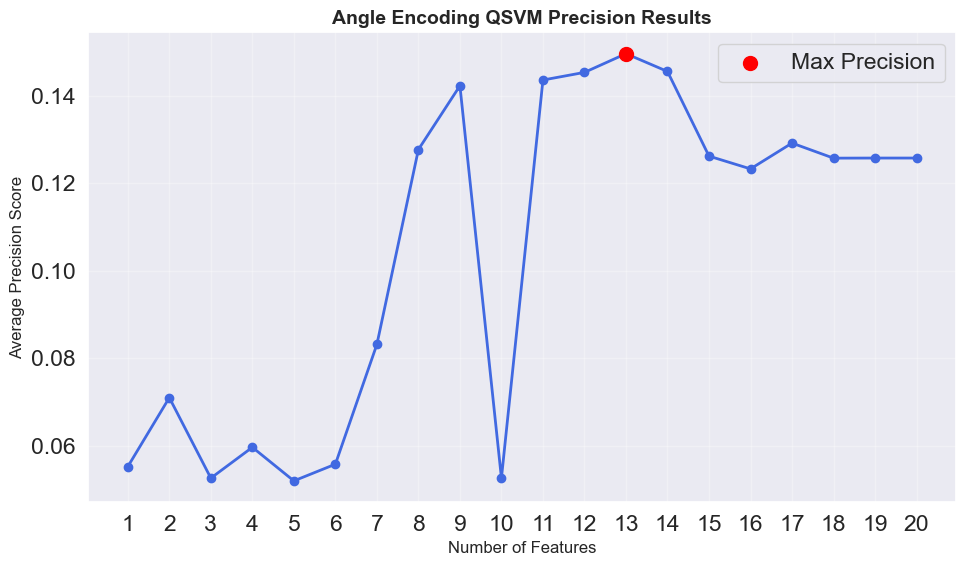

In [12]:
import matplotlib.pyplot as plt

# Your data
precision_scores = { 
    1: 0.05524604245153143, 2: 0.07100546910367217, 3: 0.052619382919242605,
    4: 0.05966530879023173, 5: 0.05198761579871551, 6: 0.05580180775607833,
    7: 0.08318165829440011, 8: 0.12771110077024017, 9: 0.14227768981767014,
    10: 0.052619382919242605, 11: 0.14359287359248618, 12: 0.14533844940031188,
    13: 0.14961111776559846, 14: 0.14555274110027785, 15: 0.12620569300653506,
    16: 0.1232865431063954, 17: 0.12918349930351822, 18: 0.1257415654160444,
    19: 0.12576461698239833, 20: 0.12576461698239833
}

# Split dictionary into x and y
features = list(precision_scores.keys())
scores = list(precision_scores.values())

# Create figure
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(features, scores, marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6)

# Grid
plt.grid(alpha=0.3)

# Labels and title
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Average Precision Score', fontsize=12)
plt.title('Angle Encoding QSVM Precision Results', fontsize=14, weight='bold')

# Highlight max point
max_idx = scores.index(max(scores))
plt.scatter(features[max_idx], scores[max_idx], color='red', s=100, zorder=5, label='Max Precision')
plt.legend()

# Set x-axis to whole numbers
plt.xticks(features)  # this ensures every number from 1 to 20 shows

# Show the plot
plt.tight_layout()
plt.show()
